In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm

from google.cloud import bigquery
from google.cloud.bigquery import job
from datetime import date, timedelta

PROJCECT = 'ballosodeuk'
bq = bigquery.Client(project=PROJCECT)

#  클라이언트 설정



### 데이터셋 준비

In [3]:
def get_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    return query

query = get_query('C:/FTC_downloads/code/git/project_hct/01-25/sql/0123_재산전체_미구매.sql')

In [4]:
df = bq.query(query).to_dataframe()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [82]:
# df.to_parquet('C:/FTC_downloads/code/git/project_hct/01-25/data/df_all_nonpurchase.parquet')
df = pd.read_parquet('C:/FTC_downloads/code/git/project_hct/01-25/data/df_all_nonpurchase.parquet')

In [83]:
df = df.query("user_id.notnull()")
df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)
df['register_dt'] = pd.to_datetime(df.register_dt.astype(str))
# # int, float 컬럼의 NA를 0으로 채우기
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)
df.fillna(0, inplace=True)

df = df[(df['register_dt'] > '2024-12-30')]
origin_df = df.copy(deep=True)



<ipython-input-83-dd904648db89>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,-1] = df.iloc[:,-1].fillna(0).astype(int)


In [84]:
# 중복 컬럼 제거
cols = list(dict.fromkeys(origin_df.columns))
origin_df = origin_df[cols]

In [85]:
origin_df.current_shoji.info()

<class 'pandas.core.series.Series'>
Int64Index: 3042411 entries, 160075 to 3202485
Series name: current_shoji
Non-Null Count    Dtype
--------------    -----
3042411 non-null  Int64
dtypes: Int64(1)
memory usage: 49.3 MB


In [86]:
origin_df.groupby('user_id')['register_dt'].transform('min')

160075    2024-12-31
160076    2024-12-31
160077    2024-12-31
160078    2024-12-31
160079    2024-12-31
             ...    
3202481   2025-01-14
3202482   2025-01-16
3202483   2025-01-18
3202484   2025-01-18
3202485   2025-01-19
Name: register_dt, Length: 3042411, dtype: datetime64[ns]

In [87]:
last_visit = origin_df.groupby('user_id')['register_dt'].max()
origin_df['churn'] = origin_df['user_id'].map(last_visit < pd.Timestamp('2025-01-15'))
origin_df['burnt_cnt'] = origin_df.burnt.apply(lambda x: 1 if x > 0 else 0)
origin_df['exchange_cnt'] = origin_df.exchange.apply(lambda x: 1 if x > 0 else 0)
origin_df['duration'] = (origin_df.groupby('user_id')['register_dt'].transform('max') - origin_df['register_dt']).dt.days
# origin_df.loc[origin_df['churn'] == False, 'duration'] = 9999

cash_diff = origin_df.groupby('user_id').agg({
   'register_dt': ['first', 'last'],
   'current_cash': ['first', 'last']
}).reset_index()

shoji_diff = origin_df.groupby('user_id').agg({
   'register_dt': ['first', 'last'],
   'current_shoji': ['first', 'last']
}).reset_index()

cash_diff['cash_difference'] = cash_diff['current_cash']['first'] - cash_diff['current_cash']['last']
shoji_diff['shoji_difference'] = shoji_diff['current_shoji']['last'] - shoji_diff['current_shoji']['first']

grp = origin_df.groupby('user_id').agg({
   'churn': 'first',
   'duration': 'first',
   'register_dt': 'first',
   'gender': 'first',
   'age': 'first',
   # 'pre_cash': 'last',
   'current_cash': 'last',
   # 'pre_shoji': 'first',
   'current_shoji':['first','last'],
   'post_shoji_1': 'first',
   'post_shoji_2': 'first',
   'post_shoji_3': 'first',
   'post_shoji_4': 'first', 
   'post_shoji_5': 'first',
   'post_shoji_6': 'first',
   'post_shoji_7': 'first',
   'post_shoji_8': 'first',
   'post_shoji_9': 'first',
   'post_shoji_10': 'first',
   'post_shoji_11': 'first',
   'post_shoji_12': 'first',
   'post_shoji_13': 'first',
   'burnt': 'sum',
   'burnt_cnt': 'sum',
   'exchange_cnt': 'sum',
   'exchange_cash_rate': 'sum'
}).reset_index()

cash_diff.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cash_diff.columns]
shoji_diff.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in shoji_diff.columns]
grp.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in grp.columns]

grp = pd.merge(grp, cash_diff[['user_id','cash_difference']], on='user_id', how='left')
grp = pd.merge(grp, shoji_diff[['user_id','shoji_difference']], on='user_id', how='left')

grp = grp.query("user_id.str.len() > 1")


In [88]:
grp.rename(columns={'current_shoji_first':'current_shoji-first', 'current_shoji_last':'current_shoji-last'}, inplace=True)
grp.columns = grp.columns.str.replace('_first', '')
grp.columns = grp.columns.str.replace('_last', '')  
grp.columns = grp.columns.str.replace('_sum', '')

In [93]:
print("보상 활동 시작 코호트 : ",grp.register_dt.min(), grp.register_dt.max())
grp = grp.query('register_dt < "2025-01-14"').churn.value_counts()



보상 활동 시작 코호트 :  2024-12-31 00:00:00 2025-01-22 00:00:00


In [69]:
# 선형 회귀로 변화 속도(기울기) 계산
from scipy import stats

def get_slope(row):
   x = np.array(range(14))
   y = np.array(row.values, dtype=float)  # 명시적으로 float 변환
   return stats.linregress(x, y)[0]

slopes = grp[['current_shoji-first'] + 
            [f'post_shoji_{i}' for i in range(1,14)]].apply(get_slope, axis=1)

grp['slope'] = slopes

In [70]:
grp.columns


Index(['user_id', 'churn', 'duration', 'register_dt', 'gender', 'age',
       'current_cash', 'current_shoji-first', 'current_shoji-last',
       'post_shoji_1', 'post_shoji_2', 'post_shoji_3', 'post_shoji_4',
       'post_shoji_5', 'post_shoji_6', 'post_shoji_7', 'post_shoji_8',
       'post_shoji_9', 'post_shoji_10', 'post_shoji_11', 'post_shoji_12',
       'post_shoji_13', 'burnt', 'burnt_cnt', 'exchange_cnt',
       'exchange_cash_rate', 'cash_difference', 'shoji_difference', 'slope'],
      dtype='object')

In [81]:
# 이탈여부 평균 생존기간
grp.groupby('churn').agg({'duration':['mean','std']})


duration          
           mean       std
churn                    
True   9.832862  5.340888

In [72]:
grp

,user_id,churn,duration,register_dt,gender,age,current_cash,current_shoji-first,current_shoji-last,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,post_shoji_7,post_shoji_8,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,burnt,burnt_cnt,exchange_cnt,exchange_cash_rate,cash_difference,shoji_difference,slope
1,000087ef-6929-4532-85be-33661b2082d5,True,14,2024-12-31,MALE,40,25905,30,747,45,57,72,87,471,486,501,516,531,546,717,732,747,0,0,0,0,0,717,62.650549
2,0000d355-7050-4a3e-90d1-2aa0b1198aba,True,0,2024-12-31,MALE,30,8636,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.285714
3,000256cd-ebbd-46ac-94e9-93a2b1ace57d,True,14,2024-12-31,MALE,30,7283,64,959,79,162,177,433,448,463,511,526,608,623,881,896,911,0,0,0,0,0,895,67.578022
4,00028da6-749d-4053-b988-3ad02b8aacfd,True,13,2025-01-01,MALE,50,367,3,24,6,9,12,15,18,21,24,27,30,33,0,0,0,0,0,0,0,0,21,0.145055
5,0002ee0b-520c-4e47-84d1-3847ecf3cc9a,True,3,2025-01-10,FEMALE,40,11963,12,24,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,-0.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242406,ffff4ddd-d4b3-4df1-bcb1-545edba93d13,True,12,2024-12-31,FEMALE,30,5284,3,79,16,25,34,37,40,46,49,55,58,64,79,0,0,0,0,0,0,0,76,1.393407
242407,ffff92f1-7756-49e9-88e9-f2e545ecddb9,True,14,2024-12-31,FEMALE,50,17951,60,273,75,81,155,188,191,200,255,258,270,273,279,282,291,0,0,0,0,0,213,18.800000
242408,ffff9afc-f69f-4c83-812f-8454f740abfb,True,14,2024-12-31,FEMALE,60,23022,75,888,86,205,217,397,409,432,442,523,571,700,770,783,888,0,0,0,0,0,813,61.371429
242409,ffff9c5c-d657-486e-97dd-716f6af8a429,True,10,2024-12-31,MALE,50,6608,18,75,33,48,63,75,90,105,120,0,0,0,0,0,0,0,0,0,0,0,57,-4.615385


In [44]:
grp.groupby(['gender','churn']).agg({
    'exchange_cnt':'mean','burnt_cnt':'mean','exchange_cash_rate':'mean',
    'cash_difference':'mean','shoji_difference':'mean',
    'current_cash':'mean',
    'current_shoji-first':'mean','current_shoji-last':'mean'
    })


exchange_cnt  burnt_cnt  exchange_cash_rate  cash_difference  \
gender churn                                                                 
FEMALE False      0.860621   0.021770          434.877224       416.118465   
       True       0.083120   0.028480           76.587197        59.963175   
MALE   False      0.908740   0.019568          430.024981       411.386285   
       True       0.101451   0.028309           86.285858        67.597719   

              shoji_difference  current_cash  current_shoji-first  \
gender churn                                                        
FEMALE False        813.032598  14229.683584           699.411754   
       True          64.012219   8386.605586           267.750544   
MALE   False        911.373607  15856.004083           679.719829   
       True          77.867053    8878.82461           269.007927   

              current_shoji-last  
gender churn                      
FEMALE False         1512.444351  
       True           331.762763  
MALE   False         1591.093435  
       True           346.874979

In [45]:
pd.set_option('display.max_columns', None)
grp

,user_id,churn,duration,register_dt,gender,age,current_cash,current_shoji-first,current_shoji-last,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,post_shoji_7,post_shoji_8,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,burnt,burnt_cnt,exchange_cnt,exchange_cash_rate,cash_difference,shoji_difference
1,000087ef-6929-4532-85be-33661b2082d5,False,21,2024-12-31,MALE,40,25905,30,862,45,57,72,87,471,486,501,516,531,546,717,732,747,0,0,0,0,0,832
2,0000d355-7050-4a3e-90d1-2aa0b1198aba,True,0,2024-12-31,MALE,30,8636,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,000256cd-ebbd-46ac-94e9-93a2b1ace57d,False,22,2024-12-31,MALE,30,7283,64,1408,79,162,177,433,448,463,511,526,608,623,881,896,911,0,0,0,0,0,1344
4,00028da6-749d-4053-b988-3ad02b8aacfd,False,20,2025-01-01,MALE,50,367,3,33,6,9,12,15,18,21,24,27,30,33,0,0,0,0,0,0,0,0,30
5,0002ee0b-520c-4e47-84d1-3847ecf3cc9a,True,3,2025-01-10,FEMALE,40,11963,12,24,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252150,ffff4ddd-d4b3-4df1-bcb1-545edba93d13,True,12,2024-12-31,FEMALE,30,5284,3,79,16,25,34,37,40,46,49,55,58,64,79,0,0,0,0,0,0,0,76
252151,ffff92f1-7756-49e9-88e9-f2e545ecddb9,False,22,2024-12-31,FEMALE,50,17951,60,318,75,81,155,188,191,200,255,258,270,273,279,282,291,0,0,0,0,0,258
252152,ffff9afc-f69f-4c83-812f-8454f740abfb,False,22,2024-12-31,FEMALE,60,23022,75,1149,86,205,217,397,409,432,442,523,571,700,770,783,888,0,0,0,0,0,1074
252153,ffff9c5c-d657-486e-97dd-716f6af8a429,False,22,2024-12-31,MALE,50,6608,18,120,33,48,63,75,90,105,120,0,0,0,0,0,0,0,0,0,0,0,102


In [15]:
df.query("user_id == '000087ef-6929-4532-85be-33661b2082d5'")

,register_dt,user_id,member_no,gender,age,pre_cash,current_cash,gender_1,age_1,pre_shoji,current_shoji,post_shoji_1,post_shoji_2,post_shoji_3,post_shoji_4,post_shoji_5,post_shoji_6,post_shoji_7,post_shoji_8,post_shoji_9,post_shoji_10,post_shoji_11,post_shoji_12,post_shoji_13,burnt,exchange,exchange_cash_rate
186884,2024-12-31,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,15,30,45,57,72,87,471,486,501,516,531,546,717,732,747,0,0,0
343406,2025-01-01,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,30,45,57,72,87,471,486,501,516,531,546,717,732,747,762,0,0,0
486699,2025-01-02,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,45,57,72,87,471,486,501,516,531,546,717,732,747,762,787,0,0,0
642266,2025-01-03,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,57,72,87,471,486,501,516,531,546,717,732,747,762,787,802,0,0,0
789229,2025-01-04,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,72,87,471,486,501,516,531,546,717,732,747,762,787,802,817,0,0,0
1053740,2025-01-06,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,87,471,486,501,516,531,546,717,732,747,762,787,802,817,832,0,0,0
1194872,2025-01-07,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,471,486,501,516,531,546,717,732,747,762,787,802,817,832,847,0,0,0
1335108,2025-01-08,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,486,501,516,531,546,717,732,747,762,787,802,817,832,847,862,0,0,0
1471284,2025-01-09,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,501,516,531,546,717,732,747,762,787,802,817,832,847,862,0,0,0,0
1604727,2025-01-10,000087ef-6929-4532-85be-33661b2082d5,99135629,MALE,40,25905,25905,MALE,40,516,531,546,717,732,747,762,787,802,817,832,847,862,0,0,0,0,0


<Axes: xlabel='register_dt'>

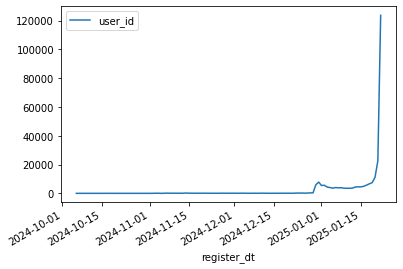

In [5]:
# last 로 필터링 했으므로, 역 지수분포 그림 나옴. 왼쪽 꼬리가 이탈\
df.groupby('register_dt').agg({'user_id':'count'}).plot()

#### 1주일 간 미적립 = 이탈 기준 적용

In [194]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_.sort_values(by='post_shoji_9',ascending=False)

### 인과 분석
재구매 유저는 행이 여러개임. 단, 매 구매 이후 이탈 확률은 동일하게 부여되므로, 독립적인 세션으로 취급.

In [ ]:
origin = origin_df.copy(deep=True)
origin.columns

In [ ]:
origin.columns

In [ ]:
origin.columns

In [ ]:
origin = origin[['register_dt','user_id','gender','age','pre_cash','current_cash', 'post_shoji_1','post_shoji_6','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt']]
origin['spending_power'] = round(origin.apply(lambda x: 0 if x['first_sub_pay_amt'] == 0 else x['first_sub_pay_amt'] / (x['first_sub_pay_amt'] + x['post_shoji_1']), axis=1), 2)
origin['survived'] = origin['post_shoji_6'] > origin['post_shoji_1']
origin = origin[origin['register_dt'] < "2025-01-15" ][['user_id','gender','age','register_dt','pre_cash','current_cash','post_shoji_1','burnt', 'exchange', 'sub_power','pre_shoji','current_shoji', 'first_pay_amt', 'first_sub_pay_amt','spending_power','survived']]


In [ ]:
len(origin),len(tst)

In [ ]:
origin.groupby('user_id').agg({'register_dt':'count'}).query('register_dt > 1')


In [ ]:
origin.groupby('survived').agg({'user_id':'count'})


In [ ]:
tst.groupby('tst').agg({'user_id':'count'})

In [ ]:
random_users = origin['user_id'].sample(n=1)
print(random_users)
tst.query('user_id in @random_users')

### 로짓 전처리

In [192]:
origin_lg = origin.copy()
origin_lg['churn'] = origin_lg.survived.apply(lambda x : 1 if x == False else 0)
origin_lg = origin_lg[origin_lg['post_shoji_1'] >= 0]

In [193]:
origin_lg.age.value_counts()
origin_lg.loc[origin_lg['age'].isin([90,120]), 'age'] = 80
origin_lg.age.value_counts()

50    2179
40    1718
60     862
30     675
20     201
70     109
80      13
10       9
Name: age, dtype: Int64

In [194]:
origin_lg.columns

Index(['user_id', 'gender', 'age', 'register_dt', 'pre_cash', 'current_cash',
       'post_shoji_1', 'burnt', 'exchange', 'sub_power', 'pre_shoji',
       'current_shoji', 'first_pay_amt', 'first_sub_pay_amt', 'spending_power',
       'survived', 'churn'],
      dtype='object')

test 1

<ipython-input-195-d4adbd665b32>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gender_encoded'] = le.fit_transform(X['gender'])
<ipython-input-195-d4adbd665b32>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age_group'] = pd.cut(X['age'],
<ipython-input-195-d4adbd665b32>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

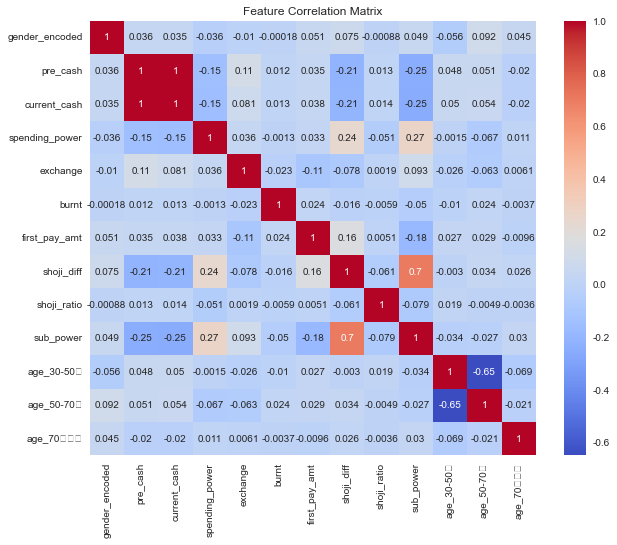


VIF Values:
                       VIF
age_30-50세        1.812441
age_50-70세        1.831969
age_70세이상         1.015780
burnt             1.004025
current_cash    309.669756
exchange          1.397959
first_pay_amt     1.252672
gender_encoded    1.023027
pre_cash        311.278505
shoji_diff        2.488125
shoji_ratio       1.007940
spending_power    1.108046
sub_power         2.613405

MinMax Scaling Results:
       gender_encoded     pre_cash  current_cash  spending_power     exchange  \
count     8890.000000  8890.000000   8890.000000     8890.000000  8890.000000   
mean         0.310402     0.063364      0.062492        0.888239     0.081398   
std          0.437054     0.081232      0.081147        0.183423     0.201665   
min          0.000000     0.000000      0.000000        0.000000     0.000000   
25%          0.000000     0.003048      0.002165        0.854400     0.000000   
50%          0.000000     0.029523      0.028099        0.968592     0.000000   
75%          0.92

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


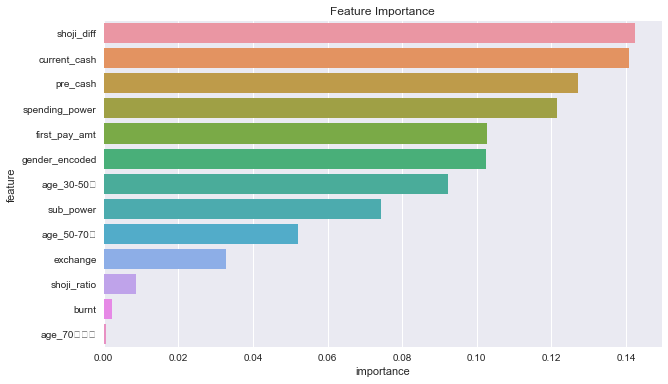

In [195]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender','pre_cash','current_cash', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['churn']

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded','pre_cash','current_cash', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['exchange'] = np.log1p(X_transformed['exchange'])
X_transformed['burnt'] = np.log1p(X_transformed['burnt'])
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

In [ ]:
vif_df

tst 2

<ipython-input-196-66ad9db3c7e4>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['exchange'] = (X['exchange'] > 0).astype(int)
<ipython-input-196-66ad9db3c7e4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['burnt'] = (X['burnt'] > 0).astype(int)
<ipython-input-196-66ad9db3c7e4>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

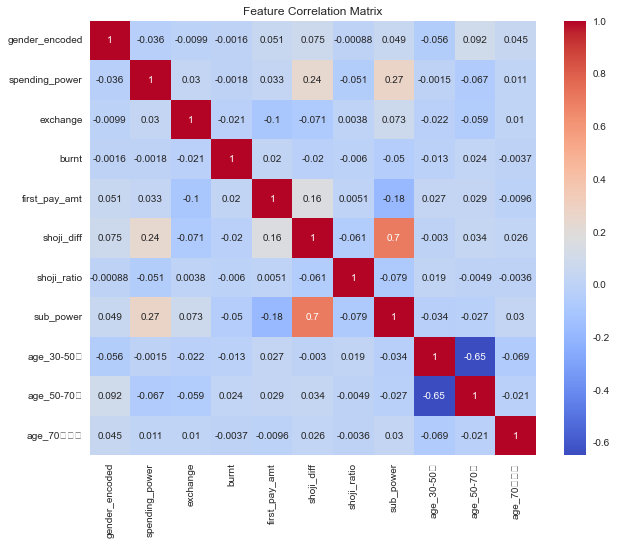


VIF Values:
                     VIF
age_30-50세      1.789522
age_50-70세      1.809536
age_70세이상       1.015574
burnt           1.003876
exchange        1.042292
first_pay_amt   1.248782
gender_encoded  1.020522
shoji_diff      2.434157
shoji_ratio     1.007773
spending_power  1.100175
sub_power       2.514029

MinMax Scaling Results:
       gender_encoded  spending_power     exchange        burnt  \
count     8890.000000     8890.000000  8890.000000  8890.000000   
mean         0.313976        0.887731     0.139958     0.005810   
std          0.437228        0.183350     0.331214     0.071602   
min          0.000000        0.000000     0.000000     0.000000   
25%          0.000000        0.848528     0.000000     0.000000   
50%          0.000000        0.969081     0.000000     0.000000   
75%          0.930135        0.994987     0.000000     0.000000   
max          1.000000        1.000000     1.000000     1.000000   

       first_pay_amt   shoji_diff   shoji_ratio    sub_pow

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


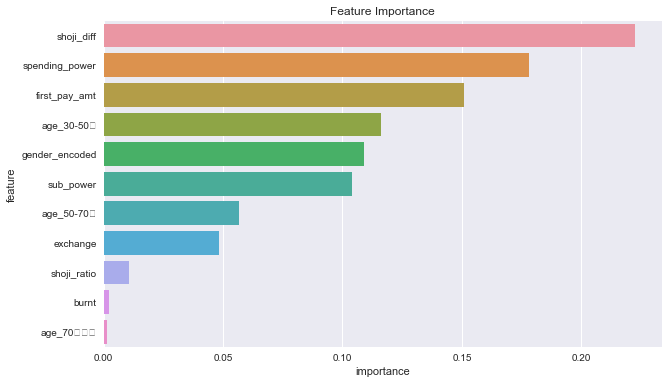

In [196]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['churn']

X['exchange'] = (X['exchange'] > 0).astype(int)
X['burnt'] = (X['burnt'] > 0).astype(int)

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded', 'spending_power', 'exchange', 'burnt', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

재산 추가

In [ ]:
origin_lg.describe()

In [ ]:
origin_lg.pre_shoji.hist()

In [ ]:
np.log1p(origin_lg.pre_shoji).hist()

In [ ]:
np.log1p(origin_lg.pre_shoji).describe()

In [ ]:
np.sqrt(origin_lg.pre_shoji).describe()

In [ ]:
# 데이터를 float 타입으로 변환 후 QQ plot 생성
pre_shoji_array = origin_lg.pre_shoji.astype(float)

# 제곱근 변환
pre_shoji_sqrt = np.sqrt(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_sqrt, dist="norm", plot=plt)
plt.title('Q-Q Plot of sqrt(pre_shoji)')
plt.show()

# 로그 변환
pre_shoji_log = np.log1p(pre_shoji_array)

plt.figure(figsize=(10, 6))
stats.probplot(pre_shoji_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of log(pre_shoji)')
plt.show()

In [ ]:
np.sqrt(origin_lg.pre_shoji).hist()

<ipython-input-197-86ea916b2437>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['exchange'] = (X['exchange'] > 0).astype(int)
<ipython-input-197-86ea916b2437>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['burnt'] = (X['burnt'] > 0).astype(int)
<ipython-input-197-86ea916b2437>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

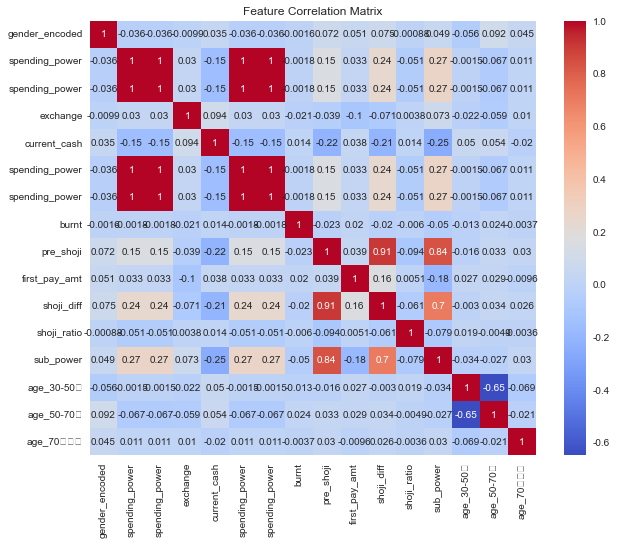


VIF Values:
                      VIF
age_30-50세       1.813745
age_50-70세       1.837990
age_70세이상        1.015809
burnt            1.005036
current_cash     1.112562
exchange         1.063153
first_pay_amt    1.255573
gender_encoded   1.022533
pre_shoji       11.917861
shoji_diff       7.011307
shoji_ratio      1.017342
spending_power   1.257093
sub_power        4.865885

MinMax Scaling Results:
       gender_encoded  spending_power  spending_power     exchange  \
count     8890.000000     8890.000000     8890.000000  8890.000000   
mean         0.312385        0.888293        0.888293     0.139633   
std          0.437834        0.182984        0.182984     0.330796   
min          0.000000        0.000000        0.000000     0.000000   
25%          0.000000        0.854400        0.854400     0.000000   
50%          0.000000        0.967668        0.967668     0.000000   
75%          0.937779        0.994987        0.994987     0.000000   
max          1.000000        1.000000 

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


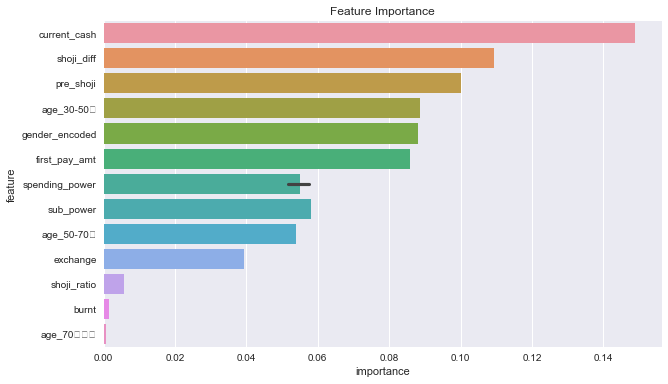

In [197]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'current_cash', 'spending_power','exchange', 'burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['churn']

X['exchange'] = (X['exchange'] > 0).astype(int)
X['burnt'] = (X['burnt'] > 0).astype(int)

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)

X = pd.concat([
    X[['gender_encoded', 'spending_power', 'exchange','current_cash', 'spending_power', 'burnt','pre_shoji', 'first_pay_amt', 
               'shoji_diff', 'shoji_ratio', 'sub_power']]
        ,age_dummies], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])
X_transformed['pre_shoji'] = np.sqrt(X_transformed['pre_shoji'])

# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

소지 캐시 구간화

In [163]:
X.columns

Index(['gender_encoded', 'spending_power', 'spending_power', 'exchange',
       'burnt', 'first_pay_amt', 'current_cash', 'spending_power',
       'spending_power', 'shoji_diff', 'shoji_ratio', 'sub_power',
       'age_30-50세', 'age_50-70세', 'age_70세이상', 'pre_shoji_낮음', 'pre_shoji_중간',
       'pre_shoji_높음', 'pre_shoji_매우높음'],
      dtype='object')

<ipython-input-217-c3ab26adeb83>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['exchange'] = (X['exchange'] > 0).astype(int)
<ipython-input-217-c3ab26adeb83>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['burnt'] = (X['burnt'] > 0).astype(int)
<ipython-input-217-c3ab26adeb83>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

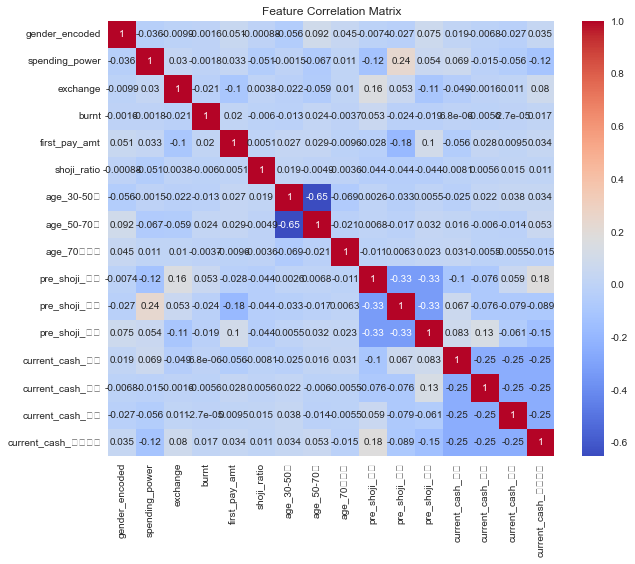


VIF Values:
                        VIF
age_30-50세         1.816629
age_50-70세         1.828475
age_70세이상          1.016486
burnt              1.004794
current_cash_낮음    1.629267
current_cash_높음    1.692493
current_cash_매우높음  1.761435
current_cash_중간    1.675133
exchange           1.066247
first_pay_amt      1.068207
gender_encoded     1.021766
pre_shoji_낮음       1.587112
pre_shoji_높음       1.603842
pre_shoji_중간       1.746654
shoji_ratio        1.019562
spending_power     1.112346

MinMax Scaling Results:
       gender_encoded  spending_power     exchange        burnt  \
count     8890.000000     8890.000000  8890.000000  8890.000000   
mean         0.308376        0.892271     0.136800     0.005320   
std          0.443621        0.180970     0.332919     0.069551   
min          0.000000        0.000000     0.000000     0.000000   
25%          0.000000        0.860233     0.000000     0.000000   
50%          0.000000        0.969536     0.000000     0.000000   
75%          1.00

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50864 (\N{HANGUL SYLLABLE U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 45458 (\N{HANGUL SYLLABLE NOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.

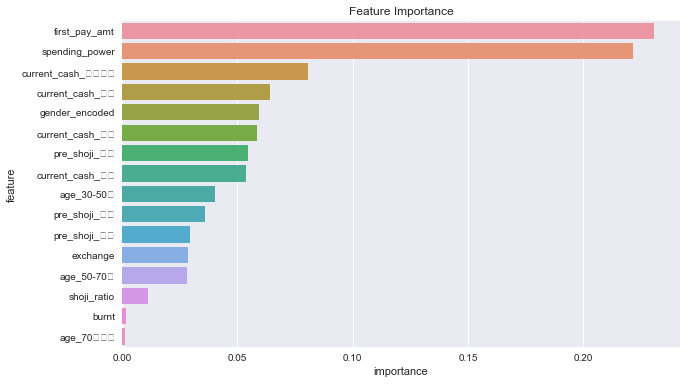

In [217]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from numpy import log1p
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


# 1. 기본 데이터 준비
X = origin_lg[['age','gender', 'spending_power', 'exchange'
               ,'current_cash', 'pre_cash','burnt', 'first_pay_amt', 
               'pre_shoji', 'post_shoji_1', 'sub_power']]
y = origin_lg['churn']

X['exchange'] = (X['exchange'] > 0).astype(int)
X['burnt'] = (X['burnt'] > 0).astype(int)

le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(X['gender'])

# 1. 구간화
pre_shoji_bins = pd.qcut(origin_lg.pre_shoji, q=4, labels=['매우낮음', '낮음', '중간', '높음'])
cur_cash_bins = pd.qcut(origin_lg.current_cash, q=5, labels=['매우낮음', '낮음', '중간', '높음', '매우높음'])
# 2. 원본 데이터에 구간 추가
origin_lg['pre_shoji_group'] = pre_shoji_bins
origin_lg['current_cash_group'] = cur_cash_bins

# 3. 원핫 인코딩
pre_shoji_dummies = pd.get_dummies(origin_lg['pre_shoji_group'], prefix='pre_shoji') + 1e-8
cur_cash_dummies = pd.get_dummies(origin_lg['current_cash_group'], prefix='current_cash') + 1e-8

# 20대를 포함한 연령대 재조정
X['age_group'] = pd.cut(X['age'], 
                       bins=[0, 30, 50, 70, 100],  # 20대 구간 추가
                       labels=['30세미만', '30-50세', '50-70세', '70세이상'])
# 다시 원핫 인코딩
age_dummies = pd.get_dummies(X['age_group'], prefix='age',drop_first=True) + 1e-8
# age_dummies = pd.get_dummies(X['age'], prefix='age',drop_first=True)

# shoji 다중공선성 해결
X['shoji_diff'] = X['pre_shoji'] - X['post_shoji_1']
X['shoji_ratio'] = X['post_shoji_1'] / (X['pre_shoji'] + 1e-8)


X = pd.concat([
   X[['gender_encoded', 'spending_power', 'exchange', 'burnt', 'first_pay_amt'
    #   ,'current_cash'
    #   ,'shoji_diff'
      ,'shoji_ratio', 
    #   'sub_power'
      ]], 
   age_dummies
   ,pre_shoji_dummies.drop('pre_shoji_매우낮음', axis=1)  # drop_first=True와 동일한 효과
   ,cur_cash_dummies.drop('current_cash_매우낮음', axis=1)  # drop_first=True와 동일한 효과
], axis=1)
# X = X.drop(['age','gender'],axis=1)
# print(X.columns)

y = y.astype(int)
X = X.astype(float)

# 2. 데이터 변환 (왜곡된 변수 처리)
X_transformed = X.copy()
X_transformed['spending_power'] = np.sqrt(X_transformed['spending_power'])



# 3. 상관관계 분석
plt.figure(figsize=(10,8))
correlation = X_transformed.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. VIF 계산
def calculate_vif(X):
    vif_dict = {}
    for column in X.columns:
        not_column = [col for col in X.columns if col != column]
        y = X[column]
        X_others = X[not_column]
        r2 = r2_score(y, LinearRegression().fit(X_others, y).predict(X_others))
        vif = 1/(1-r2)
        vif_dict[column] = vif
    return pd.DataFrame({'VIF': vif_dict})

vif_df = calculate_vif(X_transformed)
print("\nVIF Values:")
print(vif_df)

# 5. SMOTE 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_transformed, y)

# 6. 다양한 스케일러 적용 및 비교
scalers = {
    'MinMax': MinMaxScaler(),
    'Standard': StandardScaler(),
    'Robust': RobustScaler()
}

scaled_dfs = {}
for scaler_name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X_resampled)
    scaled_dfs[scaler_name] = pd.DataFrame(X_scaled, 
                                         columns=X_resampled.columns)
    
    # 스케일링 결과 통계 출력
    print(f"\n{scaler_name} Scaling Results:")
    print(scaled_dfs[scaler_name].describe())

# 7. 변수 중요도 확인
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_dfs['Standard'], y_resampled)  # StandardScaler 사용

feature_importance = pd.DataFrame({
    'feature': X_transformed.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. 최종 전처리된 데이터셋 준비
# StandardScaler를 기본으로 사용
X_final = scaled_dfs['Standard']
y_final = y_resampled

# 최종 데이터셋 통계 확인
print("\nFinal Dataset Statistics:")
print(X_final.describe())

# 결과 시각화
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.show()

In [218]:
vif_df

,VIF
age_30-50세,1.816629
age_50-70세,1.828475
age_70세이상,1.016486
burnt,1.004794
current_cash_낮음,1.629267
current_cash_높음,1.692493
current_cash_매우높음,1.761435
current_cash_중간,1.675133
exchange,1.066247
first_pay_amt,1.068207


### reg

In [219]:
# 로지스틱 회귀 분석을 위한 데이터 준비
import statsmodels.api as sm

# 상수항 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 적합
model = sm.Logit(y, X)
results = model.fit()

# 결과 출력
results.summary()


Optimization terminated successfully.
         Current function value: 0.493509
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 5766
Model:                          Logit   Df Residuals:                     5749
Method:                           MLE   Df Model:                           16
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.08302
Time:                        14:26:23   Log-Likelihood:                -2845.6
converged:                       True   LL-Null:                       -3103.2
Covariance Type:            nonrobust   LLR p-value:                 2.007e-99
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3359      0.170      1.979      0.048       0.003       0.669
gender_encoded       -0.1442      0.073     -1.988      0.047      -0.286      -0.002
spending_power        0.3989      0.155      2.572      0.010       0.095       0.703
exchange             -0.2832      0.101     -2.795      0.005      -0.482      -0.085
burnt                 0.3198      0.411      0.777      0.437      -0.486       1.126
first_pay_amt     -2.217e-06   1.89e-06     -1.172      0.241   -5.92e-06    1.49e-06
shoji_ratio        9.671e-12   8.76e-12      1.104      0.270    -7.5e-12    2.68e-11
age_30-50세           -0.4226      0.086     -4.912      0.000      -0.591      -0.254
age_50-70세           -0.6249      0.117     -5.343      0.000      -0.854      -0.396
age_70세이상            -0.7136      0.782     -0.913      0.361      -2.246       0.818
pre_shoji_낮음         -0.5868      0.096     -6.083      0.000      -0.776      -0.398
pre_shoji_중간         -0.5689      0.096     -5.918      0.000      -0.757      -0.381
pre_shoji_높음         -0.9523      0.097     -9.786      0.000      -1.143      -0.762
current_cash_낮음      -0.6938      0.092     -7.507      0.000      -0.875      -0.513
current_cash_중간      -1.1245      0.101    -11.150      0.000      -1.322      -0.927
current_cash_높음      -1.2792      0.103    -12.403      0.000      -1.481      -1.077
current_cash_매우높음    -1.7407      0.118    -14.810      0.000      -1.971      -1.510
=====================================================================================
"""

In [220]:
vif_df

,VIF
age_30-50세,1.816629
age_50-70세,1.828475
age_70세이상,1.016486
burnt,1.004794
current_cash_낮음,1.629267
current_cash_높음,1.692493
current_cash_매우높음,1.761435
current_cash_중간,1.675133
exchange,1.066247
first_pay_amt,1.068207


In [251]:
def calc_impact(results, base_prob):
    significant_vars = {var: coef for var, coef in results.params.items() 
                       if results.pvalues[var] < 0.05 and var != 'const'}
    
    impacts = {}
    const = results.params['const']
    for var, coef in significant_vars.items():
        new_prob = np.exp(const + coef)/(1 + np.exp(const + coef))
        impacts[var] = round((new_prob - base_prob) * 100, 2)
    
    return impacts
base_prob = np.exp(results.params['const'])/(1 + np.exp(results.params['const']))
impacts = calc_impact(results, base_prob)

In [289]:
base_prob

0.5832051094655817

In [296]:
(np.exp(0.3198+ 0.3359) / (1+np.exp(0.3198 + 0.3359)) - base_prob)

0.0750886831780615

In [254]:
impacts

{'gender_encoded': -3.54,
 'spending_power': 9.27,
 'exchange': -7.0,
 'age_30-50세': -10.49,
 'age_50-70세': -15.5,
 'pre_shoji_낮음': -14.56,
 'pre_shoji_중간': -14.12,
 'pre_shoji_높음': -23.26,
 'current_cash_낮음': -17.17,
 'current_cash_중간': -27.07,
 'current_cash_높음': -30.3,
 'current_cash_매우높음': -38.61}

In [175]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                 5766
Model:                          Logit   Df Residuals:                     5753
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                 0.07167
Time:                        13:54:11   Log-Likelihood:                -2880.8
converged:                       True   LL-Null:                       -3103.2
Covariance Type:            nonrobust   LLR p-value:                 1.201e-87
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5431      0.160     -3.391      0.001      -0.857      -0.229
gender_encoded    -0.1297      0.072     -1.807      0.071      -0.270       0.011
spending_power     0.6215      0.151      4.114      0.000       0.325       0.918
exchange          -0.3856      0.101     -3.828      0.000      -0.583      -0.188
burnt              0.2423      0.404      0.599      0.549      -0.550       1.034
first_pay_amt   1.185e-06   1.88e-06      0.631      0.528    -2.5e-06    4.87e-06
current_cash   -3.898e-05    2.8e-06    -13.913      0.000   -4.45e-05   -3.35e-05
shoji_diff     -4.541e-05   6.89e-06     -6.593      0.000   -5.89e-05   -3.19e-05
shoji_ratio     1.374e-11   8.87e-12      1.548      0.122   -3.65e-12    3.11e-11
sub_power          0.0632      0.128      0.493      0.622      -0.188       0.315
age_30-50세        -0.4664      0.085     -5.501      0.000      -0.633      -0.300
age_50-70세        -0.6644      0.116     -5.740      0.000      -0.891      -0.438
age_70세이상         -0.8545      0.781     -1.094      0.274      -2.386       0.677
==================================================================================
"""

In [179]:
np.exp(0.6215)

1.861718526249198

In [201]:
origin_lg.columns

Index(['user_id', 'gender', 'age', 'register_dt', 'pre_cash', 'current_cash',
       'post_shoji_1', 'burnt', 'exchange', 'sub_power', 'pre_shoji',
       'current_shoji', 'first_pay_amt', 'first_sub_pay_amt', 'spending_power',
       'survived', 'churn', 'pre_shoji_group', 'current_cash_group'],
      dtype='object')

In [203]:
origin_lg['current_cash_group'] = pd.qcut(origin_lg.current_cash, q=5, labels=['매우낮음', '낮음', '중간', '높음', '매우높음'])
origin_lg.groupby(['current_cash_group','pre_shoji_group']).agg({'churn':'sum','user_id':'count'})

churn  user_id
current_cash_group pre_shoji_group                
매우낮음               매우낮음                83      152
                   낮음                  30       96
                   중간                 172      366
                   높음                 142      343
                   매우높음                55      197
낮음                 매우낮음                85      209
                   낮음                  23      113
                   중간                  61      229
                   높음                  73      311
                   매우높음                56      291
중간                 매우낮음                81      264
                   낮음                  35      185
                   중간                  17      140
                   높음                  34      194
                   매우높음                46      370
높음                 매우낮음                80      284
                   낮음                  52      312
                   중간                  22      200
                   높음                  30      175
                   매우높음                16      183
매우높음               매우낮음                37      246
                   낮음                  59      446
                   중간                  12      220
                   높음                  13      129
                   매우높음                 7      111

In [191]:
origin_lg.survived

3        0
5        0
9        0
12       0
13       1
        ..
16502    1
16503    1
16507    0
16512    1
16513    1
Name: survived, Length: 5766, dtype: int64

unique 